In [118]:
import pandas as pd
import warnings
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [49]:
#Ignoring warnings about memory from running gridsearch with n_jobs=-1
warnings.filterwarnings('ignore')

In [6]:
fitness_df = pd.read_csv('../Data/fitness_clean.csv', index_col=0)
bodyweight_df = pd.read_csv('../Data/bodyweight_clean.csv', index_col=0)

all_posts = pd.concat([fitness_df, bodyweight_df], ignore_index=True)

In [7]:
# null model accuracy
all_posts['subreddit'].value_counts(normalize=True)

bodyweightfitness    0.512388
Fitness              0.487612
Name: subreddit, dtype: float64

In [8]:
X = all_posts['selftext']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Grid Search Basic Logistic Regression

In [12]:
pipe = make_pipeline(TfidfVectorizer(), StandardScaler(with_mean=False), 
                     LogisticRegression(max_iter=10_000))
params = {
    'tfidfvectorizer__max_features': [400, 800, 1000],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'logisticregression__C': [0.001, 0.01, 0.1]
}
grid = GridSearchCV(pipe, params, n_jobs=-1)

In [13]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1],
                         'tfidfvectorizer__max_features': [400, 800, 1000],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__stop_words': [None, 'english']})

In [14]:
grid.score(X_train, y_train)

0.8273590389459408

In [15]:
grid.score(X_test, y_test)

0.7907585004359198

In [16]:
grid.best_params_

{'logisticregression__C': 0.001,
 'tfidfvectorizer__max_features': 1000,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__stop_words': 'english'}

In [66]:
imports = pd.DataFrame(
    {
        'feature': grid.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names(),
        'coef': grid.best_estimator_.named_steps['logisticregression'].coef_[0]
    }
)

In [67]:
imports.sort_values(by='coef', ascending=False).head(10).T

,749,141,121,189,677,741,684,680,916,641
feature,rr,calisthenics,bodyweight,covid,pull,rings,pullups,pull ups,ups,planche
coef,0.196903,0.182199,0.175058,0.16813,0.151902,0.148899,0.125961,0.118797,0.117905,0.116415


In [71]:
imports.sort_values(by='coef', ascending=False).tail(10).T

,530,169,492,300,205,494,493,99,363,416
feature,machine,com,lift,fitness,deadlift,lifts,lifting,bench,gym,https
coef,-0.0761092,-0.0832037,-0.0832856,-0.0904352,-0.0935666,-0.100671,-0.121146,-0.135526,-0.14653,-0.159617


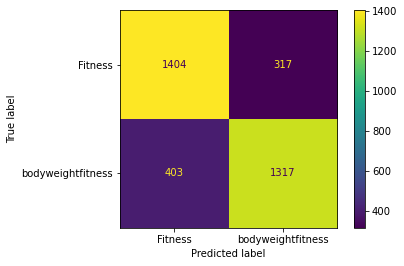

In [119]:
plot_confusion_matrix(grid, X_test, y_test);
plt.savefig('../Presentation/Images/confusion_matrix.png')

#### Results
The basic logistic regression model without preprocessing scores similarly to other models.  Without preprocessing some unwanted terms such as URL's are showing up highly correlated to fitness especially.  As can be seen from the confusion matrix, the errors are fairly well balanced with slightly more posts being predicted as fitness which should be bodyweightfitness.  This is logical since it is reasonable that a post made in bodyweightfitness could also apply to the more general fitness subreddit.

## Custom Preprocessing

In [45]:
# using isalnum method to remove special characters from
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string

def my_preprocessor(text):
    """Process text for use with vectorizer.
    
    Takes in a string and modifies it for use with count or tf-idf
    vectorizer.  It will set all characters to lowercase, remove and urls,
    remove the apostrophe from contractions, and replace non-alphanumeric
    characters with a space.
    
    Args:
        text (string): string to be processed
    
    Returns:
        string: processed text string
    """
    text = text.lower()
    text = re.sub('http\S+|www.\S+', '', text)
    text = text.replace("'", '')
    text = ''.join(w if w.isalnum() or w == ' ' else ' ' for w in text)
    
    return text

In [50]:
pipe2 = make_pipeline(TfidfVectorizer(preprocessor=my_preprocessor), 
                      StandardScaler(with_mean=False), 
                      LogisticRegression(max_iter=10_000))
grid2 = GridSearchCV(pipe2, params, n_jobs=-1)

In [51]:
grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(preprocessor=<function my_preprocessor at 0x7fd6b0194430>)),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1],
                         'tfidfvectorizer__max_features': [400, 800, 1000],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__stop_words': [None, 'english']})

In [52]:
grid2.score(X_train, y_train)

0.8223212555706259

In [53]:
grid2.score(X_test, y_test)

0.7762278407439698

In [54]:
grid2.best_params_

{'logisticregression__C': 0.001,
 'tfidfvectorizer__max_features': 1000,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__stop_words': 'english'}

#### Results
Similar but slightly lower accuracy score on the test data than without preprocessing depending on the train/test split of the data.  Could be the preprocessing preventing the stopwords from catching some things.

## Custom Tokenizer
Testing model with both a lemmatizer and stemmer.  Also processing stopwords in a similar manner.

In [55]:
def my_lemmatizer(text):
    """lemmatizer wrapper for use with vectorizer"""
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in word_tokenize(text)]

In [56]:
def my_stemmer(text):
    """PoerterStemmer wrapper for use with vectorizer"""
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

In [57]:
# apply same pre-processing to stopwords as posts 
# inspiration from https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w.replace("'",'')) for w in stopwords.words('english')]

stemmer = PorterStemmer()
stem_stopwords = [stemmer.stem(w.replace("'",'')) for w in stopwords.words('english')]

In [58]:
pipe3 = make_pipeline(
    TfidfVectorizer(preprocessor=my_preprocessor,
                    tokenizer=my_lemmatizer), 
    StandardScaler(with_mean=False), 
    LogisticRegression(max_iter=10_000)
)

params3 = {
    'tfidfvectorizer__max_features': [None, 400, 800, 1000],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__stop_words': [None, lem_stopwords],
    'logisticregression__C': [0.001, 0.01, 0.1]
}

grid3 = GridSearchCV(pipe3, params3, n_jobs=-1)

In [59]:
grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(preprocessor=<function my_preprocessor at 0x7fd6b0194430>,
                                                        tokenizer=<function my_lemmatizer at 0x7fd6e1556af0>)),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01,...
                         'tfidfvectorizer__max_features': [None, 400, 800,
                                                           1000],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__stop_words': [None,
                                                         ['i', 'me', 'm

In [60]:
grid3.score(X_train, y_train)

0.8146677000581283

In [61]:
grid3.score(X_test, y_test)

0.7741935483870968

Best Params:  
    {  
        'logisticregression__C': 0.001,  
         'tfidfvectorizer__max_features': 800,  
         'tfidfvectorizer__ngram_range': (1, 2),  
         'tfidfvectorizer__stop_words': lem_stopwords  
     }

#### Feature Importances - Custom Preprocessing and Lemmetizing

In [81]:
imports3 = pd.DataFrame(
    {
        'feature': grid3.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names(),
        'coef': grid3.best_estimator_.named_steps['logisticregression'].coef_[0]
    }
)

In [82]:
imports3.sort_values(by='coef', ascending=False).head(10).T

,597,132,145,593,179,550,201,560,735,555
feature,rr,bodyweight,calisthenics,ring,covid,pull,dip,pushup,ups,pullups
coef,0.212128,0.196464,0.193472,0.178659,0.170943,0.146941,0.144345,0.143197,0.129728,0.129149


In [83]:
imports3.sort_values(by='coef', ascending=False).tail(10).T

,207,192,126,261,436,191,408,409,316,116
feature,dumbbell,deadlifts,bike,fitness,machine,deadlift,lift,lifting,gym,bench
coef,-0.0692108,-0.0716033,-0.0746096,-0.0899629,-0.0953625,-0.106115,-0.12275,-0.126211,-0.143156,-0.143805


#### Results
The lemmatizer scores marginally better than stemming.  It also performs similarly to using the default tokenizer but removes some of the unimportant terms such as those relating to URL's which show up high in feature importance likely because of their frequency.  Compared to the MultinomialNB model, these terms with the highest correlation seem more relevant than the terms that had a high log probability in the NB model.

# Tokenize with Custom Vocabulary
Use the features with the highest importance based on coefficients found in the last model as the vocabulary for vectorizing with a new model.

In [108]:
bw_top_50 = imports3.sort_values(by='coef', ascending=False).head(50)['feature']
fit_top_50 = imports3.sort_values(by='coef', ascending=False).tail(50)['feature']

In [109]:
my_vocab = pd.concat([bw_top_50, fit_top_50])

In [110]:
# Using hyperparameters found in last search
pipe4 = make_pipeline(
    TfidfVectorizer(preprocessor=my_preprocessor,
                    tokenizer=my_lemmatizer,
                    vocabulary=my_vocab), 
    StandardScaler(with_mean=False), 
    LogisticRegression(max_iter=10_000)
)

params4 = {
    'logisticregression__C': [0.001, 0.01, 0.1,1 ]
}

grid4 = GridSearchCV(pipe4, params4, n_jobs=-1)

In [111]:
grid4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(preprocessor=<function my_preprocessor at 0x7fd6b0194430>,
                                                        tokenizer=<function my_lemmatizer at 0x7fd6e1556af0>,
                                                        vocabulary=597              rr
132      bodyweight
145    calisthenics
593            ring
179           covid
           ...     
191        deadlift
408            lift
409         lifting
316             gym
116           bench
Name: feature, Length: 100, dtype: object)),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1]})

In [112]:
grid4.score(X_train, y_train)

0.7796938577795001

In [113]:
grid4.score(X_test, y_test)

0.7666376053472828

In [114]:
grid4.best_params_

{'logisticregression__C': 0.01}

#### Results
After trying with several different numbers of vocabulary words (10, 50, 100), to few words causes the model to be overfit, but the best accuracy on the test data remains similar to previous models.  Building a custom dictionary and using it with a different model type may be somethign to persue further.

## Logistic Regression Using Post Title

In [40]:
X = all_posts['title']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
pipe5 = make_pipeline(
    TfidfVectorizer(preprocessor=my_preprocessor,
                    tokenizer=my_lemmatizer,
                    stop_words=lem_stopwords,
                    max_features=1000,
                    ngram_range=(1, 2)), 
    StandardScaler(with_mean=False), 
    LogisticRegression(max_iter=10_000, C=.001)
)

In [42]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 preprocessor=<function my_preprocessor at 0x7febe0d5ff70>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'it',
                                             'it', 'itself', ...],
                                 tokenizer=<function my_lemmatizer at 0x7fec11485790>)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregr

In [43]:
pipe5.score(X_train, y_train)

0.7831815539624104

In [44]:
pipe5.score(X_test, y_test)

0.7297297297297297

#### Results
Less accurate than using posts so not persuing further.